In [4]:
from sklearn.manifold import TSNE
from v1dd_public import ARTIFACT_DIR
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pickle
import ast
from sklearn.mixture import GaussianMixture
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import joblib

In [5]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [6]:
res3 = ['frac_res_to_on', 'frac_res_to_off', 'frac_resp_dgf', 'frac_resp_dgw', 'frac_res_to_ns118', 'frac_res_to_ns12', 'frac_resp_nm']
stim_names = ['LSN-ON', 'LSN-OFF', 'Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

features = cell_info[res3]
features.rename(columns = {
       'frac_res_to_on': "LSN-ON",
       'frac_res_to_off': "LSN-OFF",
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_318737/490132688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


In [13]:
cell_info

,Unnamed: 0.1,mouse_id,Unnamed: 0,valid_cell_index,cell_index,col_vol,column,volume,plane,x,...,dgw_pref_dir,dgf_osi,dgw_osi,dgf_dsi,dgw_dsi,dgf_ls,dgw_ls,ns12_ls,ns118_ls,nm_ls
0,8542,slc2,8542,0,0,16,1,6,0,236,...,150,0.214924,0.485850,0.143261,0.394904,0.650162,0.670042,0.941426,0.943378,0.930728
1,8543,slc2,8543,1,1,16,1,6,0,159,...,90,0.765341,0.699801,0.934434,0.180604,0.914330,0.874348,0.962018,0.940841,0.954807
2,8544,slc2,8544,2,2,16,1,6,0,193,...,240,0.447789,0.317350,0.389030,0.267353,0.655039,0.657950,0.954018,0.956597,0.921463
3,8545,slc2,8545,3,3,16,1,6,0,230,...,0,0.661951,0.464806,0.056502,0.402281,0.667079,0.674886,0.944030,0.944862,0.933212
4,8546,slc2,8546,4,4,16,1,6,0,61,...,330,0.503441,0.748724,0.523120,1.000000,0.684561,0.845968,0.962426,0.954630,0.959651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88346,31308,teto1,31308,1,10,55,5,5,5,75,...,330,0.468661,0.442844,0.431271,0.186935,0.704613,0.650555,0.958025,0.958414,0.939933
88347,31309,teto1,31309,2,14,55,5,5,5,146,...,30,0.472712,0.459277,0.115886,0.715226,0.744843,0.692046,0.960391,0.955787,0.922388
88348,31310,teto1,31310,3,22,55,5,5,5,64,...,30,0.621726,0.329101,0.511249,0.381324,0.752169,0.670320,0.948195,0.958985,0.928885
88349,31311,teto1,31311,4,23,55,5,5,5,81,...,30,0.645523,0.602708,0.314335,0.497443,0.712573,0.708187,0.969706,0.949666,0.934391


Making TSNE plots for all stimuli (cell below) took around 71 minutes on my PC

KeyboardInterrupt: 

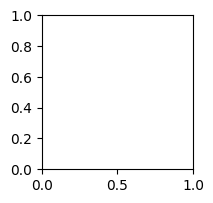

In [7]:
colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

# colors = ['#009444',
#           '#009444', # change this
#           "#21409A",
#           "#EE2A7B",
#           "#8DC63F",
#           "#F15A29"
#           "#73FF98"]

def create_tsne_plot_2d(data, labels, stim_name, ax, perplexity=30, early_exaggeration=12.0, learning_rate=200, cmap='autumn'):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
    embedding = tsne.fit_transform(data)
    unique_labels = np.unique(labels)
    label_to_color = {label: idx for idx, label in enumerate(unique_labels)}
    color_labels = np.array([label_to_color[label] for label in labels])

    sc = ax.scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        c=color_labels,
        cmap=cmap,
        alpha=0.5,
        s=0.001
    )

    plt.colorbar(sc, ax=ax)
    plt.tight_layout()
    ax.set_title(f'{stim_name}')
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')

plt.figure(figsize=(16, 2))
for j in range(7):
    X_subset = X
    X_subset_labels = features_stacked[:,j]
    ax = plt.subplot(1, 7, j+1)
    create_tsne_plot_2d(X_subset, X_subset_labels, stim_name=stim_names[j], ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


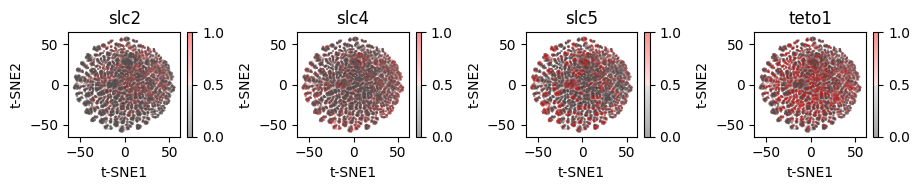

In [22]:
mouse_ids = cell_info['mouse_id'].values
mice = cell_info['mouse_id'].unique()

plt.figure(figsize=(16, 2))
for j in range(4):
    X_subset = X
    X_subset_labels = mouse_ids == mice[j]
    X_subset_labels = X_subset_labels.astype(int)
    ax = plt.subplot(1, 7, j+1)
    create_tsne_plot_2d(X_subset, X_subset_labels, stim_name=mice[j], ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

plt.savefig('/home/naomi/Desktop/figures/v1dd_plots/supp_tsne_mice.eps', format='eps', dpi=300)

In [9]:
features_stacked

array([[0.20930233, 0.18181818, 0.14285714, ..., 0.625     , 0.475     ,
        0.75      ],
       [0.06818182, 0.09090909, 0.        , ..., 0.125     , 0.05      ,
        0.125     ],
       [0.13953488, 0.22727273, 0.28571429, ..., 0.125     , 0.125     ,
        1.        ],
       ...,
       [0.13953488, 0.20454545, 0.5       , ..., 0.375     , 0.15      ,
        0.5       ],
       [0.20454545, 0.11627907, 0.25      , ..., 0.5       , 0.15      ,
        0.25      ],
       [0.18181818, 0.15909091, 0.        , ..., 0.375     , 0.15      ,
        0.5       ]])

In [ ]:
plt.scatter(X)

array([[0.20930233, 0.18181818, 0.14285714, ..., 0.625     , 0.475     ,
        0.75      ],
       [0.06818182, 0.09090909, 0.        , ..., 0.125     , 0.05      ,
        0.125     ],
       [0.13953488, 0.22727273, 0.28571429, ..., 0.125     , 0.125     ,
        1.        ],
       ...,
       [0.13953488, 0.20454545, 0.5       , ..., 0.375     , 0.15      ,
        0.5       ],
       [0.20454545, 0.11627907, 0.25      , ..., 0.5       , 0.15      ,
        0.25      ],
       [0.18181818, 0.15909091, 0.        , ..., 0.375     , 0.15      ,
        0.5       ]])

### GMM Clustering

In [ ]:
res2 = ['frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118',
        'frac_resp_nm'
       ]
features = cell_info[res2]

features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI',
       'frac_resp_nm':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_4140836/1906151156.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


In [ ]:
class CustomGMM(GaussianMixture): 
    def __init__(self, n_components=1, *, random_state=None, **kwargs): 
        super().__init__(n_components=n_components, random_state=random_state, **kwargs) 
        self.all_results_ = []
    def fit(self, X, y=None):
        super().fit(X, y) 
        result = {
                "n_components": self.n_components,
                "random_state": self.random_state,
                "log_likelihood": self.lower_bound_,
                "weights": self.weights_,
                "means": self.means_,
                "covariances": self.covariances_ 
                } 
        self.all_results_.append(result) 
        return self
    
def sum_by_class(class_labels, values):
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")

    class_sums = {}
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value
    summed_values = np.array(list(class_sums.values()))
    return summed_values

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator.bic(X)

In [ ]:
tag = "240404"

Run the following cell only once (I already ran it and the results are saved under artifacts/custering). This is trying to replicate the GMM clustering suggested in de Vries paper. However, for some reason the number of optimal cluster is very close to the max_n_components. This needs some troubleshooting. However, I tried many different numbers and in the end the number of remaining cluster classes are very consistent regardless of this initial number of clusters.

In [ ]:
# min_n_components = 1
# max_n_components = 30
# all_final_cluster_classes = []
# all_unique_classes_sorted = []
# all_summed_values = []
# all_clusters = []
# all_percent_neurons_in_mice = []
# all_mean_reliab_in_clusters_sorted = []
# all_new_class_idx_sorted = []

# for init in range(100):
#     param_grid = { 'n_components': list(range(min_n_components, max_n_components)),
#                 'random_state': [init]
#                 }
#     custom_gmm = CustomGMM() 
#     model = GridSearchCV(custom_gmm, param_grid, cv=4, n_jobs=-1, verbose=4, scoring=gmm_bic_score)
#     model.fit(X) 
#     print(f"Best Number of Clusters: {model.best_params_['n_components']} with Score: {-model.best_score_:.4f}")
    
#     clusters = model.best_estimator_.predict(X)
#     n_clusters = model.best_estimator_.means_.shape[0]
#     n_groups = 4

#     mean_reliab_in_clusters = np.zeros((n_clusters, n_groups))
#     groups_in_cluster = np.zeros((n_clusters, n_groups))

#     for cluster in range(n_clusters):
#         for g in range(n_groups):
#             cell_ind_in_cluster = np.where(clusters == cluster)[0]     
#             reliabilities_in_cluster = X[cell_ind_in_cluster, g]
#             mean_reliab_in_clusters[cluster, g] = np.nanmean(reliabilities_in_cluster)

#     cluster_means = model.best_estimator_.means_
#     cluster_means_array = np.mean(cluster_means, axis=1)
#     cluster_ind_sorted = np.argsort(cluster_means_array)
#     mean_reliab_in_clusters_sorted = mean_reliab_in_clusters[cluster_ind_sorted, :] 
#     all_mean_reliab_in_clusters_sorted.append(mean_reliab_in_clusters_sorted)
    
#     cluster_with_lowest_mean = cluster_ind_sorted[0]
    
#     # threshold for each column
#     threshold_for_each_column = mean_reliab_in_clusters[cluster_with_lowest_mean,:] + np.std(mean_reliab_in_clusters, axis = 0)
#     thresh = threshold_for_each_column

#     group_names = ["DGF","DGW","NI","NM"]
#     group_names_arr = np.asarray(group_names, dtype=object)
#     cluster_classes = []
#     cluster_assignments = mean_reliab_in_clusters_sorted > thresh
    
#     for cluster in range(n_clusters):
#         cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
#         cluster_classes.append(cluster_class)
#     unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
#     unique_classes_sorted = sorted(unique_classes, key=len)

#     classes = []
#     for x in cluster_classes:
#         index = unique_classes_sorted.index(x)
#         classes.append(index)
#     classes_arr = np.array(classes)
#     new_class_idx_sorted = np.argsort(classes_arr)
#     all_new_class_idx_sorted.append(new_class_idx_sorted)
    
#     final_cluster_classes = []
#     for cluster in range(n_clusters):
#         final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
#     final_classes = []
#     for cluster_class in final_cluster_classes:
#         index = unique_classes_sorted.index(cluster_class)
#         final_classes.append(index)

#     original_cluster_classes = []
#     cluster_assignments = mean_reliab_in_clusters > thresh
#     for cluster in range(n_clusters):
#         cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
#         original_cluster_classes.append(cluster_class)
    
#     all_final_cluster_classes.append(final_cluster_classes)
#     all_unique_classes_sorted.append(unique_classes_sorted)
   
#     percent_neurons_in_cluster = []
#     for cluster in new_class_idx_sorted:
#         cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
#         percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
#     summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
#     all_summed_values.append(summed_values)
#     all_clusters.append(clusters)

#     unique_mice = cell_info.mouse_id.unique()
#     percent_neurons_in_mouse = np.zeros((len(unique_mice)))

#     for i, mouse in enumerate(unique_mice):
#         mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

#         percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
#     all_percent_neurons_in_mice.append(percent_neurons_in_mouse)


# open_file = open(ARTIFACT_DIR / "clustering" / "all_final_cluster_classes_{tag}.pkl", "wb")
# pickle.dump(all_final_cluster_classes, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_unique_classes_sorted_{tag}.pkl", "wb")
# pickle.dump(all_unique_classes_sorted, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_summed_values_{tag}.pkl", "wb")
# pickle.dump(all_summed_values, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_clusters_{tag}.pkl", "wb")
# pickle.dump(all_clusters, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_percent_neurons_in_mice_{tag}.pkl", "wb")
# pickle.dump(all_percent_neurons_in_mice, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_mean_reliab_in_clusters_sorted_{tag}.pkl", "wb")
# pickle.dump(all_mean_reliab_in_clusters_sorted, open_file)
# open_file.close()

# open_file = open(ARTIFACT_DIR / "clustering" / "all_new_class_idx_sorted_{tag}.pkl", "wb")
# pickle.dump(all_new_class_idx_sorted, open_file)
# open_file.close()

In [ ]:
saved_model = joblib.load(ARTIFACT_DIR / "clustering" / 'grid_search_1_50_clusters_100_initializations_240315_no_lsn_ni12.pkl')

print(f"Best Number of Clusters: {saved_model.best_params_['n_components']} with Score: {-saved_model.best_score_:.4f}")

Best Number of Clusters: 48 with Score: -267305.8217


#### Load results for clusters and 100 iterations

In [ ]:
open_file = open(ARTIFACT_DIR/ "clustering" /"all_final_cluster_classes_{tag}.pkl", "rb")
all_final_cluster_classes = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_unique_classes_sorted_{tag}.pkl", "rb")
all_unique_classes_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_summed_values_{tag}.pkl", "rb")
all_summed_values = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_clusters_{tag}.pkl", "rb")
all_clusters = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_percent_neurons_in_mice_{tag}.pkl", "rb")
all_percent_neurons_in_mice = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_mean_reliab_in_clusters_sorted_{tag}.pkl", "rb")
all_mean_reliab_in_clusters_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /"all_new_class_idx_sorted_{tag}.pkl", "rb")
all_new_class_idx_sorted = pickle.load(open_file)
open_file.close()

Here I ran the analysis with 29 clusters despite the fact that the optimal number of clusters was 48 (I did anotehr run from 1-30 which gave me 29 as the number of optimal clusters but unfortunately I did not save that run, but you can run it again)

In [ ]:
all_final_cluster_classes = []
all_unique_classes_sorted = []
all_summed_values = []
all_percent_neurons_in_mice = []
all_new_class_idx_sorted = []

for init in range(100):
    
    clusters = all_clusters[init]
    n_clusters = 29
    n_groups = 4

    mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]
    
    # This is the threshold based on de Vries paper
    cluster_with_lowest_mean = 0
    threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
        np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])
    
    # you can comment the lines above and run the rest of the analyis using 3 different thresholds as in the supplmentary figure 
    # threshold2 = 0.75 # 0.25, 0.5

    group_names = ["DGF","DGW","NI","NM"]
    group_names_arr = np.asarray(group_names, dtype=object)
    cluster_classes = []
    cluster_assignments = mean_reliab_in_clusters > threshold2
    
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        cluster_classes.append(cluster_class)
    unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
    unique_classes_sorted = sorted(unique_classes, key=len)

    classes = []
    for x in cluster_classes:
        index = unique_classes_sorted.index(x)
        classes.append(index)
    classes_arr = np.array(classes)
    new_class_idx_sorted = np.argsort(classes_arr)
    all_new_class_idx_sorted.append(new_class_idx_sorted)
    
    final_cluster_classes = []
    for cluster in range(n_clusters):
        final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)

    original_cluster_classes = []
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        original_cluster_classes.append(cluster_class)
    
    all_final_cluster_classes.append(final_cluster_classes)
    all_unique_classes_sorted.append(unique_classes_sorted)
   
    percent_neurons_in_cluster = []
    for cluster in new_class_idx_sorted:
        cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
        percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
    summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
    all_summed_values.append(summed_values)
    
    unique_mice = cell_info.mouse_id.unique()
    percent_neurons_in_mouse = np.zeros((len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

        percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
    all_percent_neurons_in_mice.append(percent_neurons_in_mouse)

In [ ]:
classes_arr

array([ 0,  3,  0,  0,  0,  2,  2,  1,  2,  4,  5,  3,  7,  6,  8,  5,  3,
        6,  7,  7, 10,  8,  5,  6,  7, 10,  9, 10, 11])

In [ ]:
all_final_cluster_classes[0]

[[],
 [],
 [],
 ['DGW'],
 ['DGW'],
 ['DGW'],
 ['NM'],
 ['NM'],
 ['NM'],
 ['DGF'],
 ['NI'],
 ['NI'],
 ['NI'],
 ['DGF', 'DGW'],
 ['NI', 'NM'],
 ['NI', 'NM'],
 ['DGW', 'NM'],
 ['DGW', 'NM'],
 ['DGW', 'NI'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NI', 'NM'],
 ['DGW', 'NI', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

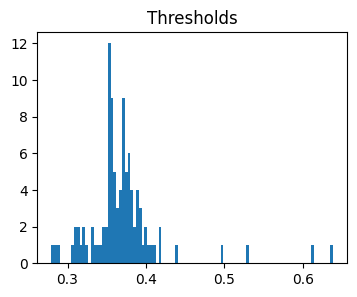

In [ ]:
thresholds = []

for init in range(100):
    mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]
    cluster_with_lowest_mean = 0 # it is already sorted
    threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
        np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])
    thresholds.append(threshold2)
    
plt.figure(figsize=((4,3)))
plt.hist(thresholds, 100)
plt.title('Thresholds')
plt.show()

### Define all unique cluster classes

In [ ]:
ordered_clusters = [
    [],
    ['DGF'],
    ['DGW'],
    ['DGF', 'DGW'],
    ['NI'],
    ['DGF', 'NI'],
    ['DGW', 'NI'],
    ['DGF', 'DGW', 'NI'],
    ['NM'],
    ['DGF', 'NM'],
    ['DGW', 'NM'],
    ['DGF', 'DGW', 'NM'],
    ['NI', 'NM'],
    ['DGW', 'NI', 'NM'],
    ['DGF', 'NI', 'NM'],
    ['DGF', 'DGW', 'NI', 'NM']
]

In [ ]:
def plot_mean_values_above_threshold_colored_order(data, values, ordered_clusters, threshold=0, plot=1, return_sorted=0): 
    # This function include 0s in mean and std
    flattened_data = [str(lst) for member in data for lst in member] 
    union_labels = list(set(flattened_data))
    means = [] 
    errors = [] 
    labels = [] 
    label_index = []
    for ilabel, label in enumerate(union_labels): 
        corresponding_values = [] 
        count = 0
        for i, member in enumerate(data): 
            for j, sublist in enumerate(member): 
                if str(sublist) == label: 
                    if isinstance(values[i][j], (list, np.ndarray)):
                        corresponding_values.extend(values[i][j].tolist()) 
                    else:
                        corresponding_values.append(values[i][j]) 
                        count += 1
        if count < threshold:
            continue
        label_index.append(ilabel)
        
        
        corresponding_values_2 = corresponding_values + [0] * (100 - len(corresponding_values))
        mean = np.mean(corresponding_values_2) 
        std_error = np.std(corresponding_values_2) / np.sqrt(len(corresponding_values_2)) 
        means.append(mean) 
        errors.append(std_error) 
        labels.append(label)
    sorted_indices = np.argsort(means)[::-1] 
    means = np.array(means)[sorted_indices].tolist() 
    errors = np.array(errors)[sorted_indices].tolist()
    labels = np.array(labels)[sorted_indices].tolist()
    new_labels = [ast.literal_eval(label) for label in labels]

    indices = [new_labels.index(label) if label in new_labels else -1 for label in ordered_clusters]
    new_means = [means[i] if i != -1 else 0 for i in indices]
    new_errs = [errors[i] if i != -1 else 0 for i in indices]
    newer_labels = [str(label) for label in ordered_clusters]
    
    n_colors = 16
    color_palette = sns.husl_palette(n_colors)
    
    if plot:
        fig = plt.figure(figsize=(10, 7)) 
        bars = plt.bar(newer_labels, new_means, yerr=new_errs, capsize=5, color=color_palette) 
        plt.xticks(rotation=45, ha="right", fontsize=10) 
        plt.yticks(fontsize=10) 
        plt.ylabel('Percent of neurons', fontsize=14) 
        plt.tight_layout() 
        plt.ylim([0, 40])
        # fig.savefig(f"clustering_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')
        
    if return_sorted:
        return sorted_indices, indices, label_index

In [ ]:
all_unique_classes_sorted[0]

[[],
 ['DGW'],
 ['NM'],
 ['DGF'],
 ['NI'],
 ['DGF', 'DGW'],
 ['NI', 'NM'],
 ['DGW', 'NM'],
 ['DGW', 'NI'],
 ['DGF', 'NM'],
 ['DGF', 'NI', 'NM'],
 ['DGW', 'NI', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

In [ ]:
all_summed_values[0]

array([13.31167729,  6.02256907, 10.63598601,  1.89584725,  9.77804439,
        5.36043735,  6.21951081,  7.72147457,  3.56192912, 11.86177859,
        3.91393419,  1.53365553, 11.54033344,  6.64282238])

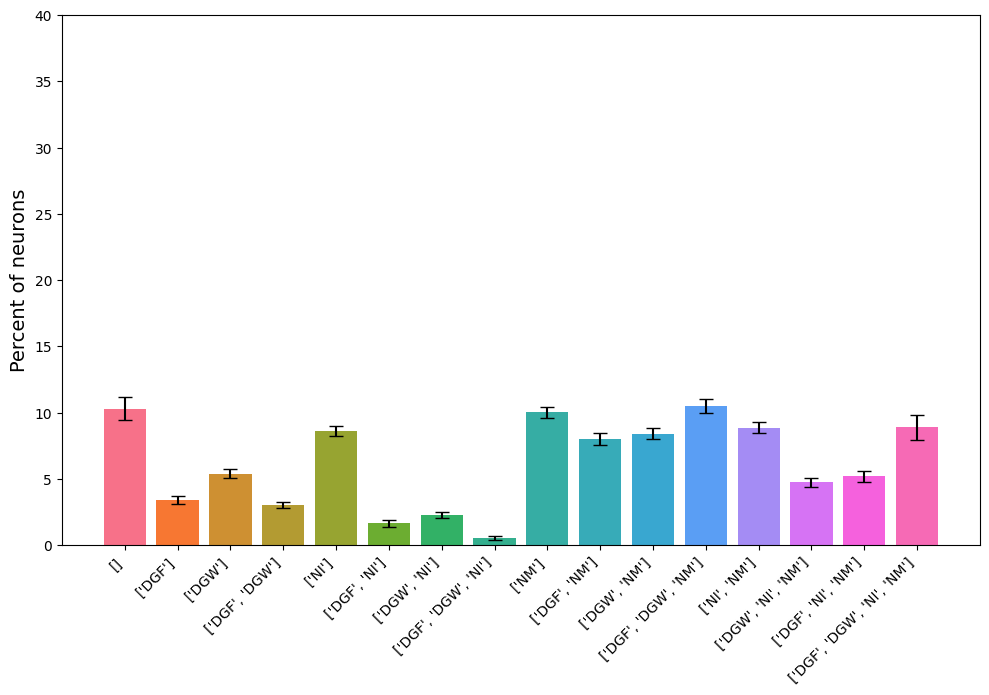

In [ ]:
plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted, all_summed_values, \
    ordered_clusters, threshold=0)

#### Plot the clusters for 1 example iteration

In [ ]:
cmap_data = { 'red': [(0, 0, 0), (0.25, 1, 1), (0.4,1,1), (1, 0.9, 0.9)], 'green': [(0, 0, 0), (0.25, 1, 1), (0.4,0.45,0.45), (1, 0, 0)], 'blue': [(0, 1, 1), (0.25, 1, 1),(0.4,0.45,0.45), (1, 0, 0)] } 
dark_red_bwr = LinearSegmentedColormap('dark_red_bwr', cmap_data) 


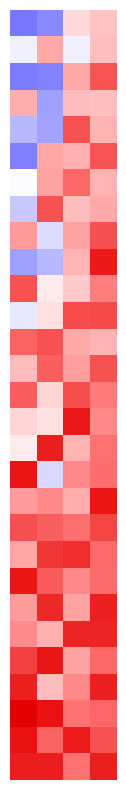

In [ ]:
iter_num = 1
mean_reliab_in_clusters_sorted = all_mean_reliab_in_clusters_sorted[iter_num]
thresh = 0.05
plt.figure(figsize=(20,10))
plt.imshow(mean_reliab_in_clusters_sorted, cmap =dark_red_bwr)
plt.clim(vmin = -np.min(thresh),vmax = 1)
plt.axis("off")
plt.show()

In [ ]:
mean_reliab_in_clusters_sorted

array([[0.07510784, 0.0900876 , 0.2573324 , 0.28207635],
       [0.19858588, 0.30822463, 0.19617945, 0.28483936],
       [0.08100793, 0.08760378, 0.30779416, 0.53689045],
       [0.30660338, 0.11679514, 0.28983583, 0.28604338],
       [0.14266238, 0.11918875, 0.55342301, 0.29697191],
       [0.08403894, 0.31148702, 0.30019014, 0.53418641],
       [0.21125085, 0.31592751, 0.43033168, 0.29510617],
       [0.15904117, 0.55005874, 0.28693262, 0.30807803],
       [0.32729417, 0.17814224, 0.3158658 , 0.56085378],
       [0.117335  , 0.14010317, 0.2979446 , 0.85295813],
       [0.55116118, 0.23503725, 0.27351304, 0.35835938],
       [0.19013969, 0.24940781, 0.57989966, 0.5900975 ],
       [0.46263194, 0.55401231, 0.30703217, 0.29511464],
       [0.2885227 , 0.48093532, 0.32174936, 0.54899368],
       [0.48888129, 0.25776869, 0.57727804, 0.36084372],
       [0.26171625, 0.24669436, 0.8674015 , 0.34410048],
       [0.23401186, 0.83880106, 0.29508377, 0.3793561 ],
       [0.87554124, 0.17467354,

In [ ]:
cluster_assignments

array([[False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False,  True, False, False],
       [False, False, False,  True],
       [ True,  True, False, False],
       [False, False,  True,  True],
       [False, False,  True, False],
       [ True, False, False,  True],
       [False,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False,  True, False],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True],
 

In [ ]:
cluster_assignments = mean_reliab_in_clusters_sorted > threshold2
group_names = ["DGF","DGW","NI","NM"]
group_names_arr = np.asarray(group_names, dtype=object)
    
for cluster in range(n_clusters):
    cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
    print(cluster_class)

[]
[]
['NM']
[]
['NI']
['NM']
['NI']
['DGW']
['NM']
['NM']
['DGF']
['NI', 'NM']
['DGF', 'DGW']
['DGW', 'NM']
['DGF', 'NI']
['NI']
['DGW', 'NM']
['DGF', 'NM']
['NM']
['DGF', 'DGW', 'NI', 'NM']
['DGW', 'NI', 'NM']
['DGF', 'DGW', 'NM']
['DGW', 'NM']
['NI', 'NM']
['DGF', 'DGW', 'NM']
['DGF', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']


#### Find the union of clusters across 100 iterations

In [ ]:
def union_lists(data):
    result = [] 
    for member in data:
        for lst in member: 
            if lst not in result: 
                result.append(lst) 
    return result 

cluster_union = union_lists(all_unique_classes_sorted) 
print(f"There are {len(cluster_union)} unique clusters across 100 iterations.")

There are 16 unique clusters across 100 iterations.


#### Plot percent for each mouse and each cluster

In [ ]:
flattened_data = [str(lst) for member in all_unique_classes_sorted for lst in member] 
union_classes = list(set(flattened_data)) 
len(union_classes)

16

In [ ]:
unique_mice = cell_info.mouse_id.unique()
all_percent_neurons_in_cluster_class_mouse_80 = np.zeros((100,len(union_classes), len(unique_mice)))
union_classes_lst_of_lsts = [ast.literal_eval(item) for item in union_classes]


In [ ]:
def create_output_array(a, b, c): 
    output = np.zeros(len(a))
    for i, element_a in enumerate(a):
        if element_a in b:
            idx = b.index(element_a) 
            output[i] = c[idx] 
    return output

In [ ]:
def sum_by_class(class_labels, values):
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")
    class_sums = {}
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value
    summed_values = np.array(list(class_sums.values()))

    return summed_values

In [ ]:

for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_class_mouse = np.zeros((len(unique_classes_sorted), len(unique_mice)))
    mean_percent_neurons_in_cluster_mouse = np.zeros((len(new_class_idx_sorted), len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        for cluster in new_class_idx_sorted:
            mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

            cell_ind_in_cluster_mouse = np.where((clusters == cluster))[0]
            cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_mouse]
            cluster_mouse_cell_info = cluster_cell_info.loc[cluster_cell_info["mouse_id"] == mouse]

            mean_percent_neurons_in_cluster_mouse[cluster, i] = len(cluster_mouse_cell_info)*100/ len(mouse_cell_info)
        percent_neurons_in_cluster_class_mouse[:,i] = sum_by_class(final_classes, mean_percent_neurons_in_cluster_mouse[:, i].tolist())
        
        all_percent_neurons_in_cluster_class_mouse_80[iter_num,:,i] = create_output_array(union_classes_lst_of_lsts, \
            unique_classes_sorted, percent_neurons_in_cluster_class_mouse[:,i]) 

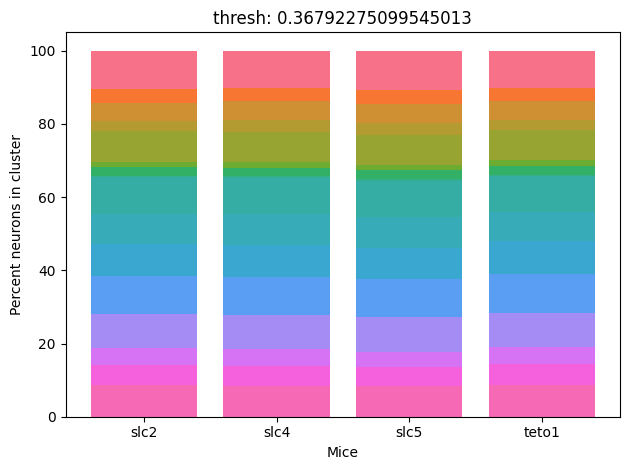

In [ ]:

sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

percent_neurons_in_cluster_class_mouse = np.zeros((16,4))

for idx, val in enumerate(indices):
    if val != -1:
        percent_neurons_in_cluster_class_mouse[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_mouse_80[:, sorted_indices_1[val], :], axis=0)


n_colors = 16#all_percent_neurons_in_cluster_class_mouse_80.shape[1]
color_palette = sns.husl_palette(n_colors)

data = percent_neurons_in_cluster_class_mouse
num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8
data_flipped = np.flip(data, axis=0)
color_palette_flipped = np.flip(color_palette, axis=0)
bottom = np.zeros(num_bars)
fig=plt.figure()
for i in range(num_shades):
    bar = plt.bar(x, data_flipped[i, :], width=bar_width, bottom=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Mice')
plt.ylabel('Percent neurons in cluster')
plt.title(f"thresh: {threshold2}")
plt.xticks(x, ["slc2", "slc4", "slc5", "teto1"])
plt.tight_layout()
# fig.savefig(f"per_mouse_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')


### Plot percent for each depth

In [ ]:
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
   [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

In [ ]:
total_vol_plane_pairs = len(z_groups_low_to_high)
all_percent_neurons_in_cluster_class_volume_80 = np.zeros((100,len(union_classes),13))


for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_volume = np.zeros((len(new_class_idx_sorted), total_vol_plane_pairs))
    z_num = 0

    for z_group in z_groups_low_to_high:
            plane_volume_cell_info = cell_info.loc[cell_info["z"].isin(z_group)]
            for cluster in new_class_idx_sorted:
                cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
                cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_1_g0]
                cluster_volume_plane_cell_info = cluster_cell_info.loc[cluster_cell_info["z"].isin(z_group)]
                
                if len(plane_volume_cell_info) != 0:
                    percent_neurons_in_cluster_volume[cluster, z_num] = len(cluster_volume_plane_cell_info)*100/len(plane_volume_cell_info)
            if len(plane_volume_cell_info) != 0:
                z_num += 1
    percent_neurons_in_cluster_class_volume = np.zeros((len(unique_classes_sorted), total_vol_plane_pairs))

    for vol_plane_pair in range(total_vol_plane_pairs):

        percent_neurons_in_cluster_volume_list = percent_neurons_in_cluster_volume[:,vol_plane_pair].tolist()
        percent_neurons_in_cluster_class_volume[:,vol_plane_pair] = sum_by_class(final_classes, percent_neurons_in_cluster_volume_list)

        all_percent_neurons_in_cluster_class_volume_80[iter_num,:,vol_plane_pair] = \
            create_output_array(union_classes_lst_of_lsts, unique_classes_sorted,  \
                percent_neurons_in_cluster_class_volume[:,vol_plane_pair])

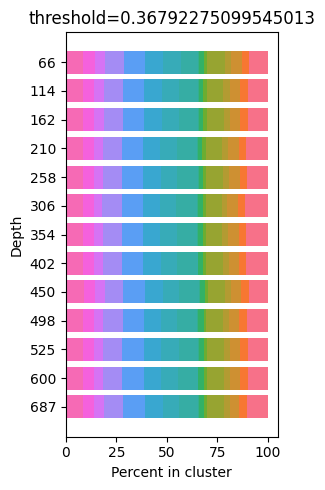

In [ ]:
sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

all_percent_neurons_in_cluster_class_mouse_19_ordered = np.zeros((16,13))

for idx, val in enumerate(indices):
    if val != -1:
        all_percent_neurons_in_cluster_class_mouse_19_ordered[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_volume_80[:, sorted_indices_1[val], :], axis=0)
data = np.array(all_percent_neurons_in_cluster_class_mouse_19_ordered)

n_colors = 16
color_palette = sns.husl_palette(n_colors)
color_palette_flipped = np.flip(color_palette, axis=0)

num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8
data_flipped = np.flip(data, axis=0)
bottom = np.zeros(num_bars)
means = [np.mean(group) for group in z_groups_low_to_high]
data_flipped = data_flipped[:, ::-1]
means = means[::-1]
x = np.arange(13)

fig = plt.figure(figsize=(3,5))
for i in range(num_shades):
    plt.barh(x, data_flipped[i, :], left=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Percent in cluster')
plt.ylabel('Depth')
plt.yticks(ticks=x, labels=[f'{int(mean)}' for mean in means])
plt.title(f"threshold={threshold2}")
plt.tight_layout()
# fig.savefig(f"per_depth_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')